In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DIR_ = "C:/Users/javie/Documents/Workspace/MIMIC DATA/mimic-iii-clinical-database-1.4/"
DIR = "D:/Workspace/MIMIC DATA/mimic-iii-clinical-database-1.4/"

In [3]:
adm_notes = pd.read_csv(DIR + "readmission.csv", low_memory=False)

# Natural Language

In [4]:
import string
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [5]:
def clean_text(texts):
    texts = texts.fillna(' ')
    texts = texts.str.replace('\n',' ')
    texts = texts.str.replace('\r',' ')

    table = str.maketrans('', '', string.punctuation + '0123456789')
    texts = [text.lower().translate(table) for text in texts]

    return texts

In [6]:
adm_notes['TEXT'] = clean_text(adm_notes['TEXT'])

In [7]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['patient', 'date', 'admission', 'discharge', 'lastname', 'firstname', 'sex']

In [8]:
porter = PorterStemmer()

In [9]:
def tokenize_stem(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [porter.stem(word) for word in words]
    return words

# Model
## Words, Train and Test

In [10]:
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_validate
from xgboost import XGBClassifier

Repartition data

In [11]:
df_train, df_test = train_test_split(adm_notes, test_size=0.3)

Subsample non-readmitted patients to match size of readmitted ones

In [12]:
rows_pos = df_train['READM_WITHIN_30'] == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos))], axis = 0)
df_train = df_train.sample(n = len(df_train)).reset_index(drop = True)

In [13]:
rows_pos = df_test['READM_WITHIN_30'] == 1
df_test_pos = df_test.loc[rows_pos]
df_test_neg = df_test.loc[~rows_pos]

df_test = pd.concat([df_test_pos, df_test_neg.sample(n = len(df_test_pos))], axis = 0)
df_test = df_test.sample(n = len(df_test)).reset_index(drop = True)

In [14]:
df_test, df_valid = train_test_split(df_test, test_size=0.5)

In [15]:
print(df_train.shape)
print(df_test.shape)
print(df_valid.shape)

(4410, 10)
(916, 10)
(916, 10)


Sparse Matrix with word count

In [16]:
vect = CountVectorizer(lowercase = True, max_features = 3000, tokenizer = tokenize_stem)
vect.fit(df_train['TEXT'].values)

X_train_tf = vect.transform(df_train['TEXT'].values)
X_test_tf = vect.transform(df_test['TEXT'].values)
X_valid_tf = vect.transform(df_valid['TEXT'].values)

y_train = df_train['READM_WITHIN_30']
y_test = df_test['READM_WITHIN_30']
y_valid = df_valid['READM_WITHIN_30']

## XGBoost Early Stopping

In [22]:
grid = {
    'min_child_weight': [3, 5],
    'gamma': [0, 0.5, 1, 1.5],
    'max_depth': [3, 4, 5],
    'eta': [0.1,0.01,0.001]
}

model_xgb = GridSearchCV(XGBClassifier(), param_grid=grid)
model_xgb.fit(X_test_tf, y_test)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,

In [23]:
model_xgb.best_params_

{'eta': 0.1, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 3}

In [34]:
eval_set = [(X_train_tf, y_train), (X_test_tf, y_test)]
model_xgb = XGBClassifier(
    eta=0.1, gamma=1, max_depth=3, min_child_weight=3
).fit(X_train_tf, y_train, eval_metric=['auc', 'error'], eval_set=eval_set, early_stopping_rounds=20)

[0]	validation_0-auc:0.64833	validation_0-error:0.38821	validation_1-auc:0.59974	validation_1-error:0.42249
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-auc:0.66268	validation_0-error:0.36916	validation_1-auc:0.61147	validation_1-error:0.41703
[2]	validation_0-auc:0.68590	validation_0-error:0.35964	validation_1-auc:0.63174	validation_1-error:0.41485
[3]	validation_0-auc:0.69294	validation_0-error:0.36236	validation_1-auc:0.62959	validation_1-error:0.39956
[4]	validation_0-auc:0.70271	validation_0-error:0.35896	validation_1-auc:0.63187	validation_1-error:0.40284
[5]	validation_0-auc:0.71044	validation_0-error:0.34830	validation_1-auc:0.63866	validation_1-error:0.40065
[6]	validation_0-auc:0.71703	validation_0-error:0.34717	validation_1-auc:0.64285	validation_1-error:0.40720
[7]	validation_0-auc:0.72020	validation_0-error:0.34513	validation_1-auc:0.64800	va

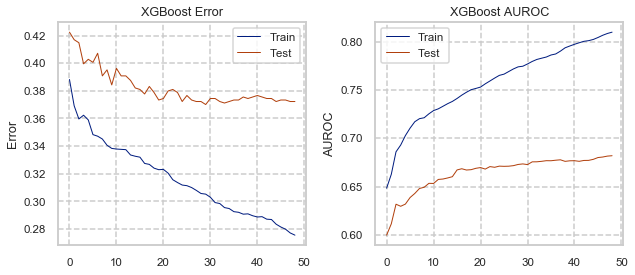

In [35]:
results = model_xgb.evals_result()

sns.set('talk', 'whitegrid', 'dark', font_scale=0.7,
        rc={"lines.linewidth": 1, 'grid.linestyle': '--'})

x_axis = range(0, len(results['validation_0']['auc']))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax[0].plot(x_axis, results['validation_0']['error'], label='Train')
ax[0].plot(x_axis, results['validation_1']['error'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost Error')
ax[0].set(ylabel='Error')

ax[1].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[1].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost AUROC')
ax[1].set(ylabel='AUROC')

fig.tight_layout()
plt.savefig('earlystopping_xgb.pgf')

In [36]:
y_train_preds = model_xgb.predict(X_train_tf)
y_valid_preds = model_xgb.predict(X_valid_tf)

In [37]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_preds)
fprt, tprt, thresholds = metrics.roc_curve(y_valid, y_valid_preds)

auc_train, auc_test = metrics.auc(fpr, tpr), metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_valid, y_valid_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_valid, y_valid_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_valid, y_valid_preds)

In [38]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.6947845804988663 0.6367570355935119
Accuracy	 0.6947845804988663 0.6397379912663755
Precission	 0.7273689782953944 0.6384615384615384
Recall		 0.6231292517006802 0.5684931506849316


## XGBoost Regularization

In [39]:
grid = {
    'min_child_weight': [3, 5],
    'gamma': [0, 0.5, 1, 1.5],
    'max_depth': [3, 4, 5],
    'eta': [0.1,0.01,0.001],
    'reg_lambda': [0, 0.5, 0.1, 0.01]
}

model_xgb = GridSearchCV(XGBClassifier(), param_grid=grid)
model_xgb.fit(X_test_tf, y_test)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
             iid=

In [40]:
model_xgb.best_params_

{'eta': 0.01,
 'gamma': 1.5,
 'max_depth': 5,
 'min_child_weight': 3,
 'reg_lambda': 0.1}

In [41]:
model_xgb = XGBClassifier(
    eta=0.01, gamma=1.5, max_depth=5, min_child_weight=3, reg_lambda=0.1
).fit(X_train_tf, y_train)

In [42]:
y_train_preds = model_xgb.predict(X_train_tf)
y_valid_preds = model_xgb.predict(X_valid_tf)

In [43]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_preds)
fprt, tprt, thresholds = metrics.roc_curve(y_valid, y_valid_preds)

auc_train, auc_test = metrics.auc(fpr, tpr), metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_valid, y_valid_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_valid, y_valid_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_valid, y_valid_preds)

In [44]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7594104308390023 0.6177375288970405
Accuracy	 0.7594104308390023 0.6200873362445415
Precission	 0.8001049317943337 0.6113861386138614
Recall		 0.691609977324263 0.5639269406392694


## Early Stop with L2 Regularization

In [45]:
eval_set = [(X_train_tf, y_train), (X_test_tf, y_test)]
model_xgb = XGBClassifier(
        eta=0.01, gamma=1.5, max_depth=5, min_child_weight=3, reg_lambda=0.1
).fit(X_train_tf, y_train, eval_metric=['auc', 'error'], eval_set=eval_set, early_stopping_rounds=20)

[0]	validation_0-auc:0.71362	validation_0-error:0.33401	validation_1-auc:0.59695	validation_1-error:0.42249
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-auc:0.73328	validation_0-error:0.31519	validation_1-auc:0.61066	validation_1-error:0.41812
[2]	validation_0-auc:0.74479	validation_0-error:0.31134	validation_1-auc:0.60474	validation_1-error:0.42795
[3]	validation_0-auc:0.74540	validation_0-error:0.31383	validation_1-auc:0.61046	validation_1-error:0.42795
[4]	validation_0-auc:0.74803	validation_0-error:0.31383	validation_1-auc:0.61365	validation_1-error:0.42358
[5]	validation_0-auc:0.75055	validation_0-error:0.30703	validation_1-auc:0.61925	validation_1-error:0.42031
[6]	validation_0-auc:0.74960	validation_0-error:0.30703	validation_1-auc:0.61771	validation_1-error:0.41703
[7]	validation_0-auc:0.75123	validation_0-error:0.30884	validation_1-auc:0.62060	va

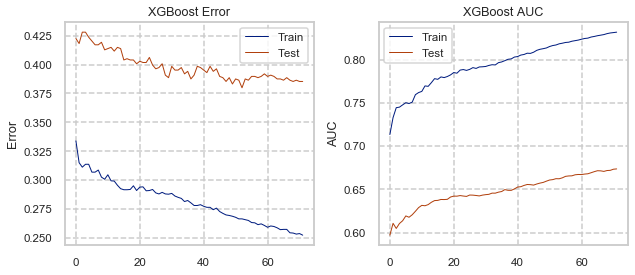

In [46]:
results = model_xgb.evals_result()
x_axis = range(0, len(results['validation_0']['auc']))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax[0].plot(x_axis, results['validation_0']['error'], label='Train')
ax[0].plot(x_axis, results['validation_1']['error'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost Error')
ax[0].set(ylabel='Error')

ax[1].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[1].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost AUC')
ax[1].set(ylabel='AUC')

fig.tight_layout()
plt.savefig('earlystopping_xgb_L2.pgf')

In [47]:
y_train_preds = model_xgb.predict(X_train_tf)
y_valid_preds = model_xgb.predict(X_valid_tf)

In [48]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_preds)
fprt, tprt, thresholds = metrics.roc_curve(y_valid, y_valid_preds)

auc_train, auc_test = metrics.auc(fpr, tpr), metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_valid, y_valid_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_valid, y_valid_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_valid, y_valid_preds)

In [49]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7333333333333334 0.618496971781204
Accuracy	 0.7333333333333333 0.62117903930131
Precission	 0.7822270981897971 0.6146095717884131
Recall		 0.6467120181405895 0.5570776255707762
